In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.optim as optim
from random import randint
import statistics
import torch.distributions as tdist

In [5]:
class Policy_Net(nn.Module):
    def __init__(self):
        super(Policy_Net, self).__init__()
        self.l1 = nn.Linear(33,64)
        self.l2 = nn.Linear(64,64)
        self.l3 = nn.Linear(64,4)

    def forward(self, state):
        state = F.tanh(self.l1(state))
        state = F.tanh(self.l2(state))
        state = F.tanh(self.l3(state))
        return state
    
class Critic_Net(nn.Module):
    def __init__(self):
        super(Critic_Net, self).__init__()
        self.l1 = nn.Linear(33,64)
        self.l2 = nn.Linear(64,64)
        self.l3 = nn.Linear(64,1)

    def forward(self, state):
        state = F.tanh(self.l1(state))
        state = F.tanh(self.l2(state))
        state = F.tanh(self.l3(state))
        return state

In [2]:
class Actor():
    def __init__(self,action_size, discount_rate, p_net, c_net):
        self.pi = p_net
        self.value_est = c_net
        self.optimizer = optim.Adam(self.pi.parameters(), lr=0.001)
        self.optimizer2 = optim.RMSprop(self.value_est.parameters(), lr=0.001)
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, 0.995)
        self.scheduler2 = optim.lr_scheduler.ExponentialLR(self.optimizer2, 0.99)
        self.discount = discount_rate
        #Used to create covariance matrix to get actions and calculate action probability
        #Covariance is always 0, Variance annealed to 0.5
        self.var = torch.tensor([2.0])
    def get_action(self,state):
        prob = self.pi(torch.from_numpy(state).float())
        prob = tdist.multivariate_normal.MultivariateNormal(prob[:,:action_space], torch.eye(4) * self.var)
        return torch.clamp(prob.sample(),-1,1)

In [14]:
num_episodes = 350
action_space = 4
epsilon = 0.2
pi = Policy_Net()
critic = Critic_Net()
Agent = Actor(33, 0.99, pi,critic)
traj_list = list()
traj_rewards = list()
batch_size = 150
batches = 100
av_rew = 0
discount = 0.96#Low discount rate resulted in better performance, likely due to nature of environment
rew_list = list()
advantage_rewards = list()
advantage_list = list()
score_list = list()
traj_num = 1#How often to update policy

In [15]:

for episode in range(num_episodes):
    score = 0
    env_info = env.reset(train_mode=True)[brain_name]
    s0 = env_info.vector_observations 
    traj_list.append(list())
    traj_rewards.append(list())
    advantage_rewards.append(list())
    advantage_list.append(list())
    game_score = 0
    for frame in range(1000000):
        if frame > -1:
            action = Agent.get_action(s0)
        else:
            action = 0  
        env_info = env.step(action.detach().numpy())[brain_name]
        reward = np.array(env_info.rewards)
        state = env_info.vector_observations
        game_score += sum(reward)/20
        if frame > -1:
            av_rew += sum(reward)/20
            traj_list[-1].append([s0, action, state])
            traj_rewards[-1].append(reward)
        s0 = state
        #Ends when done
        if np.any(env_info.local_done):
            score_list.append(game_score)
            break
    #Get discounted rewards to train value function
    advantage_rewards[-1] = deepcopy(traj_rewards[-1])
    weighted_rewards = 0
    for i in reversed(range(len(traj_rewards[-1])-1)):
        advantage_rewards[-1][i] += advantage_rewards[-1][i+1] * discount
    l = 0.96
    cur_advantage = 0
    advantage_list[-1] = deepcopy(advantage_rewards[-1])
    #Calculates Advantage Using Generalized Advantage Estimatior
    for i in reversed(range(len(traj_rewards[-1]))):
        new_adv = torch.from_numpy(traj_rewards[-1][i]).float().view((20,1)) + discount * Agent.value_est(torch.from_numpy(traj_list[-1][i][2]).float()) - Agent.value_est(torch.from_numpy(traj_list[-1][i][0]).float())
        cur_advantage = cur_advantage * l * discount + new_adv
        advantage_list[-1][i] = cur_advantage
    #Update Policy
    if episode%traj_num == 0 and episode > -1:
        advantage_mean = sum([torch.mean(i) for j in advantage_list for i in j])/len([torch.mean(i) for j in advantage_list for i in j])
        advantage_std = sum([torch.std(i)**2 for j in advantage_list for i in j])**0.5
        old_pi = deepcopy(Agent.pi)
        for batch in range(batches):
            loss = 0
            for i in range(batch_size):
                m = randint(0,len(traj_list)-1)
                traj = traj_list[m]
                n = randint(0,len(traj)-1)
                o = randint(0,19)
                #Calculates probability of picking action
                dist = Agent.pi(torch.from_numpy(traj[n][0][o]).float())
                var = Agent.var
                dist = dist[:action_space]
                dist = tdist.multivariate_normal.MultivariateNormal(dist, torch.eye(4) * Agent.var)
                prob = dist.log_prob(torch.tensor(traj[n][1][o]))
                #Calculates old probability of picking action
                old_dist = old_pi(torch.from_numpy(traj[n][0][o]).float())
                old_var = Agent.var
                old_dist = old_dist[:action_space]
                old_dist = tdist.multivariate_normal.MultivariateNormal(old_dist, torch.eye(4) * Agent.var)
                old_prob = old_dist.log_prob(torch.tensor(traj[n][1][o]))
                
                ratio = torch.exp(prob-old_prob)
                advantage = (advantage_list[m][n][o] - advantage_mean)/(advantage_std+0.0001)
                #Clipping terms
                if advantage[0] > 0:
                    loss += torch.min(ratio, torch.from_numpy(np.array(1 + epsilon)).float()) * -1 * advantage
                else:
                    loss += torch.max(ratio, torch.from_numpy(np.array(1 - epsilon)).float()) * -1 * advantage
            Agent.optimizer.zero_grad()
            loss.backward(retain_graph=True)
            Agent.optimizer.step()
            
        #Update value function
        if episode > 10:
            x = 50
        else:
            x = 200
        for batch in range(x):
            loss2 = 0
            for i in range(200):
                m = randint(0,len(traj_list)-1)
                traj = traj_list[m]
                n = randint(0,len(traj)-1)
                o = randint(0,19)
                loss2 += (torch.from_numpy(advantage_rewards[m][n]).float()[o] - Agent.value_est(torch.from_numpy(traj[n][0][o]).float())[0])**2
            Agent.optimizer2.zero_grad()
            loss2.backward(retain_graph=True)
            Agent.optimizer2.step()
        print('last action prob :' + str(prob))
        print('1 game average :' + str(av_rew/traj_num))
        rew_list.append(av_rew/traj_num)
        print('total game average :' + str(sum(rew_list)/len(rew_list)))
        av_rew = 0
        traj_list = list()
        traj_rewards = list()
        advantage_rewards = list()
        advantage_list = list()
        #Anneals learning rate
        Agent.scheduler.step()
        Agent.scheduler2.step()
        #Slowly anneals variance to 0.5. Too low variance resulted in loss of performance
        if Agent.var > 0.5:
            Agent.var *= 0.995

last action prob :tensor(-5.5611)
1 game average :0.225999994948506
total game average :0.225999994948506
last action prob :tensor(-5.6808)
1 game average :0.32999999262392526
total game average :0.27799999378621565
last action prob :tensor(-5.1842)
1 game average :0.5129999885335577
total game average :0.35633332536866297
last action prob :tensor(-6.7789)
1 game average :0.6684999850578628
total game average :0.43437499029096294
last action prob :tensor(-6.4992)
1 game average :0.6804999847896417
total game average :0.4835999891906987
last action prob :tensor(-6.1649)
1 game average :0.5449999878183018
total game average :0.49383332229529914
last action prob :tensor(-5.0554)
1 game average :0.6159999862313293
total game average :0.5112857028575892
last action prob :tensor(-6.0813)
1 game average :0.8664999806322196
total game average :0.555687487579418
last action prob :tensor(-5.3172)
1 game average :1.2404999722726633
total game average :0.6317777636564452
last action prob :tensor(-

last action prob :tensor(-5.8055)
1 game average :4.609499896969644
total game average :2.0312948263918873
last action prob :tensor(-5.2899)
1 game average :5.2574998824857095
total game average :2.0721328650766195
last action prob :tensor(-5.7714)
1 game average :4.558499898109576
total game average :2.1032124529895313
last action prob :tensor(-4.8380)
1 game average :5.741499871667481
total game average :2.148129581615185
last action prob :tensor(-4.2552)
1 game average :5.413999878987682
total game average :2.187957268168508
last action prob :tensor(-4.5286)
1 game average :5.4289998786524
total game average :2.227005974318917
last action prob :tensor(-4.2300)
1 game average :4.557999898120745
total game average :2.2547559019832244
last action prob :tensor(-6.5335)
1 game average :5.60999987460672
total game average :2.2942293604846773
last action prob :tensor(-5.0027)
1 game average :6.6639998510479845
total game average :2.345040645258669
last action prob :tensor(-4.9998)
1 game a

last action prob :tensor(-3.9189)
1 game average :16.052499641198672
total game average :6.527661144417978
last action prob :tensor(-5.0362)
1 game average :18.10149959539992
total game average :6.601852416539657
last action prob :tensor(-4.6826)
1 game average :15.390999655984357
total game average :6.65783424609026
last action prob :tensor(-3.7859)
1 game average :14.859499667864306
total game average :6.709743520911616
last action prob :tensor(-4.2227)
1 game average :16.07599964067336
total game average :6.7686507921050865
last action prob :tensor(-4.8594)
1 game average :15.142999661527561
total game average :6.820990472538976
last action prob :tensor(-3.9075)
1 game average :16.95949962092563
total game average :6.883962579050695
last action prob :tensor(-3.9568)
1 game average :17.10099961776284
total game average :6.947030708919289
last action prob :tensor(-4.0624)
1 game average :16.954999621026182
total game average :7.0084292912021535
last action prob :tensor(-3.7452)
1 game

last action prob :tensor(-4.5502)
1 game average :27.022499396000086
total game average :11.381730349046775
last action prob :tensor(-3.4205)
1 game average :28.787499356549272
total game average :11.456433220323609
last action prob :tensor(-3.1814)
1 game average :28.69699935857204
total game average :11.530110853393047
last action prob :tensor(-3.0286)
1 game average :28.328499366808657
total game average :11.601593357705454
last action prob :tensor(-2.9152)
1 game average :27.261999390646892
total game average :11.667951010387409
last action prob :tensor(-3.2571)
1 game average :29.55449933940546
total game average :11.743421678442338
last action prob :tensor(-3.7143)
1 game average :28.401999365165818
total game average :11.813415702336135
last action prob :tensor(-3.5414)
1 game average :30.67499931436039
total game average :11.89233446221908
last action prob :tensor(-4.7985)
1 game average :29.379999343305805
total game average :11.965199732556943
last action prob :tensor(-6.2464

last action prob :tensor(-3.2372)
1 game average :38.040499149728795
total game average :17.116818387635846
last action prob :tensor(-4.3330)
1 game average :38.05099914949407
total game average :17.18434800299668
last action prob :tensor(-3.5245)
1 game average :38.264499144721924
total game average :17.252129839465248
last action prob :tensor(-4.3862)
1 game average :38.6074991370552
total game average :17.320576535931885
last action prob :tensor(-3.9486)
1 game average :38.49499913956983
total game average :17.388226448403568
last action prob :tensor(-3.1308)
1 game average :38.373499142285574
total game average :17.455058527046504
last action prob :tensor(-5.3498)
1 game average :38.32849914329132
total game average :17.521323417891725
last action prob :tensor(-2.9076)
1 game average :38.50899913925684
total game average :17.5877401132125
last action prob :tensor(-2.8664)
1 game average :38.273999144509574
total game average :17.65299645085066
last action prob :tensor(-5.2087)
1 ga

In [20]:
#Saves Model
torch.save(Agent.pi.state_dict(), 'Reacher_PPO_Actor')
torch.save(Agent.value_est.state_dict(),'Reacher_PPO_Critic')

30.06057432809384


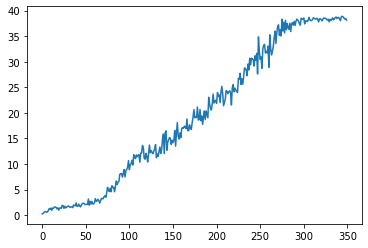

In [36]:
#Plots learning curve
plt.plot(score_list)
print(sum(score_list[195:295])/100)

In [ ]:
### Run with trained model
pi = Policy_Net()
critic = Critic_Net()
Agent = Actor(33, 0.99, pi,critic)
Agent.pi.load_state_dict(torch.load('Reacher_PPO_Actor'))
Agent.value_est.load_state_dict(torch.load('Reacher_PPO_Critic'))
Agent.var = torch.tensor([0.001])
env_info = env.reset(train_mode=False)[brain_name]     
states = env_info.vector_observations                  
scores = 0                        
while True:
    action = Agent.get_action(states)
    env_info = env.step(action.detach().numpy())[brain_name]           
    next_states = env_info.vector_observations         
    rewards = env_info.rewards                        
    dones = env_info.local_done                       
    scores += sum(env_info.rewards)                        
    states = next_states                               
    if np.any(dones):                                  
        break
print('Score: ' + str(scores/20))